## The goal of this project was to develop an effective policy under poor weather conditions when the Lidar is not completely reliable and when drivers can become agressive.

In [1]:
using POMDPs, QuickPOMDPs, POMDPModelTools, POMDPSimulators, QMDP, POMDPPolicies
using Distributions
using Parameters
using BeliefUpdaters
using Plots
using StaticArrays

┌ Warning: Error requiring `UnicodePlots` from `Plots`
│   exception = (LoadError("C:\\Users\\cveda\\.julia\\packages\\Plots\\CBYO0\\src\\backends\\unicodeplots.jl", 77, UndefVarError(:UserColorType)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000002684a81, Ptr{Nothing} @0x000000000271282b, Ptr{Nothing} @0x000000000eb29de7, Ptr{Nothing} @0x0000000002711afc, Ptr{Nothing} @0x00000000027116f4, Ptr{Nothing} @0x0000000002712048, Ptr{Nothing} @0x0000000002712c85, Base.InterpreterIP in top-level CodeInfo for Plots at statement 3, Ptr{Nothing} @0x000000000272f287, Ptr{Nothing} @0x000000000272fdc1, Ptr{Nothing} @0x0000000002730d0f, Ptr{Nothing} @0x000000000f104dfb, Ptr{Nothing} @0x000000000f104a1f, Ptr{Nothing} @0x000000000ebb50c8, Ptr{Nothing} @0x00000000027059e6, Ptr{Nothing} @0x0000000061038b76, Ptr{Nothing} @0x0000000002711afc, Ptr{Nothing} @0x00000000027116f4, Ptr{Nothing} @0x0000000002712048, Ptr{Nothing} @0x0000000002712c85, Base.InterpreterIP in top-level CodeInfo for 

In [2]:
@with_kw struct RacecarParameters
    # Rewards
    r_crash::Real = -100 #Terminal State
    r_avoided_stop::Real = -4 #Terminal State
    r_avoided_continue::Real = 20 # No crash yet by continuing straight.
    r_avoided_left::Real = -6 #Avoided crach changing to the left lane
    r_avoided_right::Real = -5 #Avoided crash by changing to the right lane,which is better because drivers are going slower
    
    # Transition probability
    p_threat_arises::Real = .15   #Probability that a car behind or infront of us becomes a threat
    p_crash_when_continue_wthreat::Real = .5 #The probability that you crash when continuing with agressive driver
    #Obervation probabilities
    p_collision_detected::Real = .7 # Suboptimal conditions when the lidar only has a 70% chance of detecting the collision
    p_false_alarm::Real = .1        # when no threat
end

RacecarParameters

In [3]:
params = RacecarParameters();

In [4]:
begin
    @enum State Crash Collision_AC Collision_AS Collision_AL Collision_AR 
    @enum Action Continue Stop Left_T Right_T 
    @enum Observation Collision_D Collision_U
end

In [5]:
𝒮 = [Crash, Collision_AC, Collision_AS, Collision_AL, Collision_AR]

5-element Vector{State}:
 Crash::State = 0
 Collision_AC::State = 1
 Collision_AS::State = 2
 Collision_AL::State = 3
 Collision_AR::State = 4

In [6]:
𝒜 = [Continue, Stop, Left_T, Right_T]

4-element Vector{Action}:
 Continue::Action = 0
 Stop::Action = 1
 Left_T::Action = 2
 Right_T::Action = 3

In [7]:
𝒪 = [Collision_D, Collision_U]

2-element Vector{Observation}:
 Collision_D::Observation = 0
 Collision_U::Observation = 1

In [8]:
initialstate_distr = Deterministic(Collision_AC)

Deterministic{State}(Collision_AC)

In [9]:
function T(s::State, a::Action)
    p_Crash_I::Real = params.p_crash_when_continue_wthreat
    p_Threat::Real = params.p_threat_arises
    p_Crash::Real = p_Threat*p_Crash_I
    if a == Stop # Even if car tries to stop there would still be a slim chance of crashing
        return SparseCat([Crash, Collision_AC, Collision_AS, Collision_AL, Collision_AR], [.15,0,.85,0,0])
    elseif a == Right_T  # If we make a right lanechange there is still a possibility that we crash into an adjacent car
        return SparseCat([Crash, Collision_AC, Collision_AS, Collision_AL, Collision_AR], [.1,0,0,0,])
    elseif a == Left_T # In a left lanechange there is a higher chance of a crash because the cars are moving faster
        return SparseCat([Crash, Collision_AC, Collision_AS, Collision_AL, Collision_AR], [.18,0,0,.82,0]) 
    elseif a == Continue #While continuing p_crash = prob of threat arrising * prob of crash w/threat
        return SparseCat([Crash, Collision_AC, Collision_AS, Collision_AL, Collision_AR], [p_Crash,1-p_Crash,0,0])
    elseif s == Crash # No transitioning when you have crashed
         return SparseCat([Crash, Collision_AC, Collision_AS, Collision_AL, Collision_AR], [1,0,0,0,0])
   elseif s == Collision_AS # No transitioning when you have stopped.
         return SparseCat([Crash, Collision_AC, Collision_AS, Collision_AL, Collision_AR], [0,0,1,0,0])
    else
        return SparseCat([Crash, Collision_AC, Collision_AS, Collision_AL, Collision_AR], [p_Crash,1-p_Crash,0,0,0])
    end
end

T (generic function with 1 method)

In [10]:
function O(s::State, a::Action, sp::State)
    p_Threat::Real = params.p_threat_arises
    p_True_Detect = params.p_collision_detected
    p_False_Detect = params.p_false_alarm
    p_Normal = p_Threat*p_True_Detect + (1-p_Threat)*p_False_Detect
    if sp == Crash 
        return SparseCat([Collision_D, Collision_U], [p_True_Detect, 1-p_True_Detect])
    elseif sp == Collision_AC # If there was no crash, any collision detection must have been a false alarm.
        return SparseCat([Collision_D, Collision_U], [p_False_Detect, 1-p_False_Detect])
    else
        return SparseCat([Collision_D, Collision_U], [p_Normal,1-p_Normal])
    end
end        

O (generic function with 1 method)

In [11]:
function R(s::State, a::Action)
    return(s == Crash ? params.r_crash : 0) + (a == Continue ? params.r_avoided_continue : 0) + 
                                              (a == Stop ? params.r_avoided_stop : 0) +
                                              (a == Left_T ? params.r_avoided_left : 0) + 
                                              (a == Right_T ? params.r_avoided_right : 0) 
end

R (generic function with 1 method)

In [12]:
# R(Collision_AC, Continue)

In [13]:
γ = 0.9

0.9

In [14]:
abstract type Racecar <: POMDP{State, Action, Observation}end

In [15]:
pomdp = QuickPOMDP(Racecar,
    states = 𝒮,
    actions = 𝒜,
    observations = 𝒪,
    transition = T,
    reward = R,
    observation = O,
    discount = γ,
    initialstate = initialstate_distr);

In [16]:
struct ActWhenThreat <: Policy end

In [17]:
struct ActWhenBelievedThreat <: Policy end

In [18]:
const Belief = Vector{Real};

In [19]:
function POMDPs.action(::ActWhenThreat, o::Observation)
    return o == Collision_D ? Stop : Continue
end;

In [20]:
function POMDPs.action(::ActWhenBelievedThreat, b::Belief)
    if b[1] > b[2]
        return Stop
    else
        return Continue
    end
end;

In [21]:
updater(pomdp::QuickPOMDP{Racecar}) = DiscreteUpdater(pomdp)

updater (generic function with 1 method)

In [22]:
b0 = uniform_belief(pomdp); b0.b

5-element Vector{Float64}:
 0.2
 0.2
 0.2
 0.2
 0.2

In [23]:
begin 
    a1 = Continue 
    o1 = Collision_U
    b1 = update(DiscreteUpdater(pomdp), b0, a1, o1)
    b1.b
end

5-element Vector{Float64}:
 0.026315789473684213
 0.9736842105263158
 0.0
 0.0
 0.0

In [24]:
using BasicPOMCP

In [25]:
pomcp_solver = POMCPSolver(c = 500)

POMCPSolver
  max_depth: Int64 20
  c: Float64 500.0
  tree_queries: Int64 1000
  max_time: Float64 Inf
  tree_in_info: Bool false
  default_action: ExceptionRethrow ExceptionRethrow()
  rng: Random._GLOBAL_RNG Random._GLOBAL_RNG()
  estimate_value: RolloutEstimator


In [26]:
pomcp_planner = solve(pomcp_solver, pomdp);

In [27]:
initialstate(pomdp)

Deterministic{State}(Collision_AC)

In [28]:
aₚ, info = action_info(pomcp_planner, initialstate(pomdp), tree_in_info=true); aₚ

Continue::Action = 0

In [29]:
using D3Trees

In [30]:
pomcp_tree = D3Tree(info[:tree], init_expand=3)

o: <root>
N: 1000      
├──a: Continue
│  N: 613    
│  V: -190      
│  ├──o: Collision_U
│  │  N: 530       
│  │  ├──a: Continue
│  │  │  N: 317    
│  │  │  V: -195       (2 children)
│  │  ├──a: Stop
│  │  │  N: 101    
│  │  │  V: -251       (2 children)
│  │  ├──a: Left_T
│  │  │  N: 71     
│  │  │  V: -275       (2 children)
│  │  └──a: Right_T
│  │     N: 41     
│  │     V: -322       (2 children)
│  └──o: Collision_D
│     N: 81        
│     ├──a: Continue
│     │  N: 25     
│     │  V: -256       (2 children)
│     ├──a: Stop
│     │  N: 21     
│     │  V: -277       (2 children)
│     ├──a: Left_T
│     │  N: 24     
│     │  V: -266       (2 children)
│     └──a: Right_T
│        N: 11     
│        V: -367       (2 children)
├──a: Stop
│  N: 176    
│  V: -238      
│  ├──o: Collision_U
│  │  N: 131       
│  │  ├──a: Continue
│  │  │  N: 53     
│  │  │  V: -209       (2 children)
│  │  ├──a: Stop
│  │  │  N: 28     
│  │  │  V: -270       (2 children)
│  │  ├──a: Left_T
│  │  │  N: 33     
│  │  │  V: -255       (2 children)
│  │  └──a: Right_T
│  │     N: 17     
│  │     V: -335       (2 children)
│  └──o: Collision_D
│     N: 43        
│     ├──a: Continue
│     │  N: 17     
│     │  V: -220       (2 children)
│     ├──a: Stop
│     │  N: 8      
│     │  V: -356       (2 children)
│     ├──a: Left_T
│     │  N: 12     
│     │  V: -297       (2 children)
│     └──a: Right_T
│        N: 6      
│        V: -412       (2 children)
├──a: Left_T
│  N: 160    
│  V: -243      
│  ├──o: Collision_D
│  │  N: 52        
│  │  ├──a: Continue
│  │  │  N: 17     
│  │  │  V: -216       (2 children)
│  │  ├──a: Stop
│  │  │  N: 13     
│  │  │  V: -259       (2 children)
│  │  ├──a: Left_T
│  │  │  N: 13     
│  │  │  V: -279       (2 children)
│  │  └──a: Right_T
│  │     N: 9      
│  │     V: -327       (2 children)
│  └──o: Collision_U
│     N: 106       
│     ├──a: Continue
│     │  N: 44     
│     │  V: -222       (2 children)
│     ├──a: Stop
│     │  N: 24     
│     │  V: -275       (2 children)
│     ├──a: Left_T
│     │  N: 22     
│     │  V: -286       (2 children)
│     └──a: Right_T
│        N: 16     
│        V: -330       (2 children)
└──a: Right_T
   N: 51     
   V: -323      
   ├──o: Collision_D
   │  N: 36        
   │  ├──a: Continue
   │  │  N: 12     
   │  │  V: -307       (1 children)
   │  ├──a: Stop
   │  │  N: 7      
   │  │  V: -414       (2 children)
   │  ├──a: Left_T
   │  │  N: 10     
   │  │  V: -347       (2 children)
   │  └──a: Right_T
   │     N: 7      
   │     V: -401       (2 children)
   └──o: Collision_U
      N: 13        
      ├──a: Continue
      │  N: 3      
      │  V: -350       (2 children)
      ├──a: Stop
      │  N: 4      
      │  V: -314       (2 children)
      ├──a: Left_T
      │  N: 4      
      │  V: -292       (2 children)
      └──a: Right_T
         N: 2      
         V: -416       (1 children)

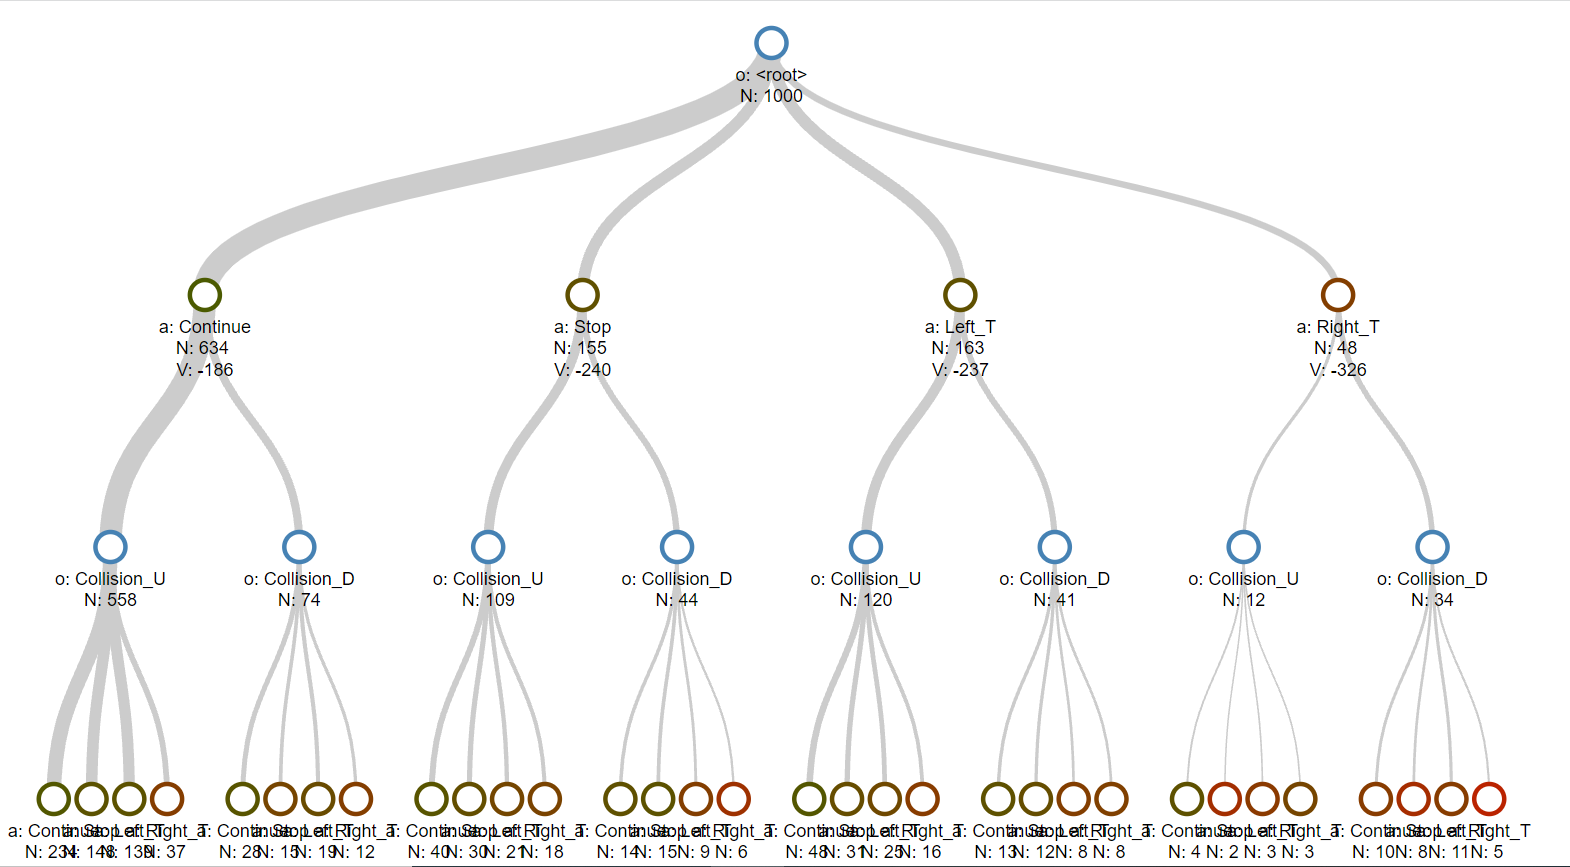

In [31]:
inchrome(pomcp_tree)

Process(`cmd /C start chrome 'C:\Users\cveda\AppData\Local\Temp\jl_6XYfdO\tree.html'`, ProcessExited(0))

In [32]:
using POMCPOW

In [33]:
pomcpow_solver = POMCPOWSolver(criterion = MaxUCB(1000))

POMCPOWSolver{Random._GLOBAL_RNG}
  eps: Float64 0.01
  max_depth: Int64 9223372036854775807
  criterion: MaxUCB
  final_criterion: MaxQ MaxQ()
  tree_queries: Int64 1000
  max_time: Float64 Inf
  rng: Random._GLOBAL_RNG Random._GLOBAL_RNG()
  node_sr_belief_updater: POMCPOW.POWNodeFilter POMCPOW.POWNodeFilter()
  estimate_value: RolloutEstimator
  enable_action_pw: Bool true
  check_repeat_obs: Bool true
  check_repeat_act: Bool true
  tree_in_info: Bool false
  alpha_observation: Float64 0.5
  k_observation: Float64 10.0
  alpha_action: Float64 0.5
  k_action: Float64 10.0
  init_V: Float64 0.0
  init_N: Int64 0
  next_action: MCTS.RandomActionGenerator{Random._GLOBAL_RNG}
  default_action: ExceptionRethrow ExceptionRethrow()


In [34]:
pomcpow_planner = solve(pomcpow_solver, pomdp);

In [35]:
aₚ, info = action_info(pomcpow_planner, initialstate(pomdp), tree_in_info=true); aₚ

Continue::Action = 0

In [36]:
using D3Trees

In [37]:
pomcpow_tree = D3Tree(info[:tree], init_expand=3)

o: <root>
N: 1000      

├──a: Continue
│  N: 412     V: -241      
│  ├──o: Collision_U
│  │  N: 359       

│  │  ├──a: Right_T
│  │  │  N: 52      V: -367       (2 children)
│  │  ├──a: Left_T
│  │  │  N: 104     V: -269       (2 children)
│  │  ├──a: Stop
│  │  │  N: 90      V: -285       (2 children)
│  │  └──a: Continue
│  │     N: 113     V: -256       (2 children)
│  └──o: Collision_D
│     N: 51        

│     ├──a: Right_T
│     │  N: 10      V: -399       (2 children)
│     ├──a: Left_T
│     │  N: 16      V: -283       (2 children)
│     ├──a: Stop
│     │  N: 12      V: -370       (2 children)
│     └──a: Continue
│        N: 13      V: -321       (2 children)
├──a: Stop
│  N: 219     V: -289      
│  ├──o: Collision_U
│  │  N: 141       

│  │  ├──a: Stop
│  │  │  N: 31      V: -331       (2 children)
│  │  ├──a: Left_T
│  │  │  N: 33      V: -320       (2 children)
│  │  ├──a: Right_T
│  │  │  N: 27      V: -374       (2 children)
│  │  └──a: Continue
│  │     N: 50      V: -248       (2 children)
│  └──o: Collision_D
│     N: 76        

│     ├──a: Stop
│     │  N: 20      V: -331       (2 children)
│     ├──a: Right_T
│     │  N: 13      V: -436       (2 children)
│     ├──a: Left_T
│     │  N: 21      V: -314       (2 children)
│     └──a: Continue
│        N: 22      V: -299       (2 children)
├──a: Right_T
│  N: 117     V: -354      
│  ├──o: Collision_U
│  │  N: 39        

│  │  ├──a: Stop
│  │  │  N: 10      V: -386       (2 children)
│  │  ├──a: Right_T
│  │  │  N: 8       V: -470       (2 children)
│  │  ├──a: Left_T
│  │  │  N: 10      V: -403       (2 children)
│  │  └──a: Continue
│  │     N: 11      V: -346       (2 children)
│  └──o: Collision_D
│     N: 76        

│     ├──a: Stop
│     │  N: 20      V: -366       (2 children)
│     ├──a: Continue
│     │  N: 23      V: -341       (2 children)
│     ├──a: Left_T
│     │  N: 18      V: -408       (2 children)
│     └──a: Right_T
│        N: 15      V: -446       (2 children)
└──a: Left_T
   N: 252     V: -277      
   ├──o: Collision_D
   │  N: 84        

   │  ├──a: Continue
   │  │  N: 23      V: -303       (2 children)
   │  ├──a: Stop
   │  │  N: 21      V: -336       (2 children)
   │  ├──a: Left_T
   │  │  N: 23      V: -309       (2 children)
   │  └──a: Right_T
   │     N: 17      V: -381       (2 children)
   └──o: Collision_U
      N: 166       

      ├──a: Right_T
      │  N: 28      V: -363       (2 children)
      ├──a: Left_T
      │  N: 47      V: -266       (2 children)
      ├──a: Continue
      │  N: 50      V: -256       (2 children)
      └──a: Stop
         N: 41      V: -291       (2 children)

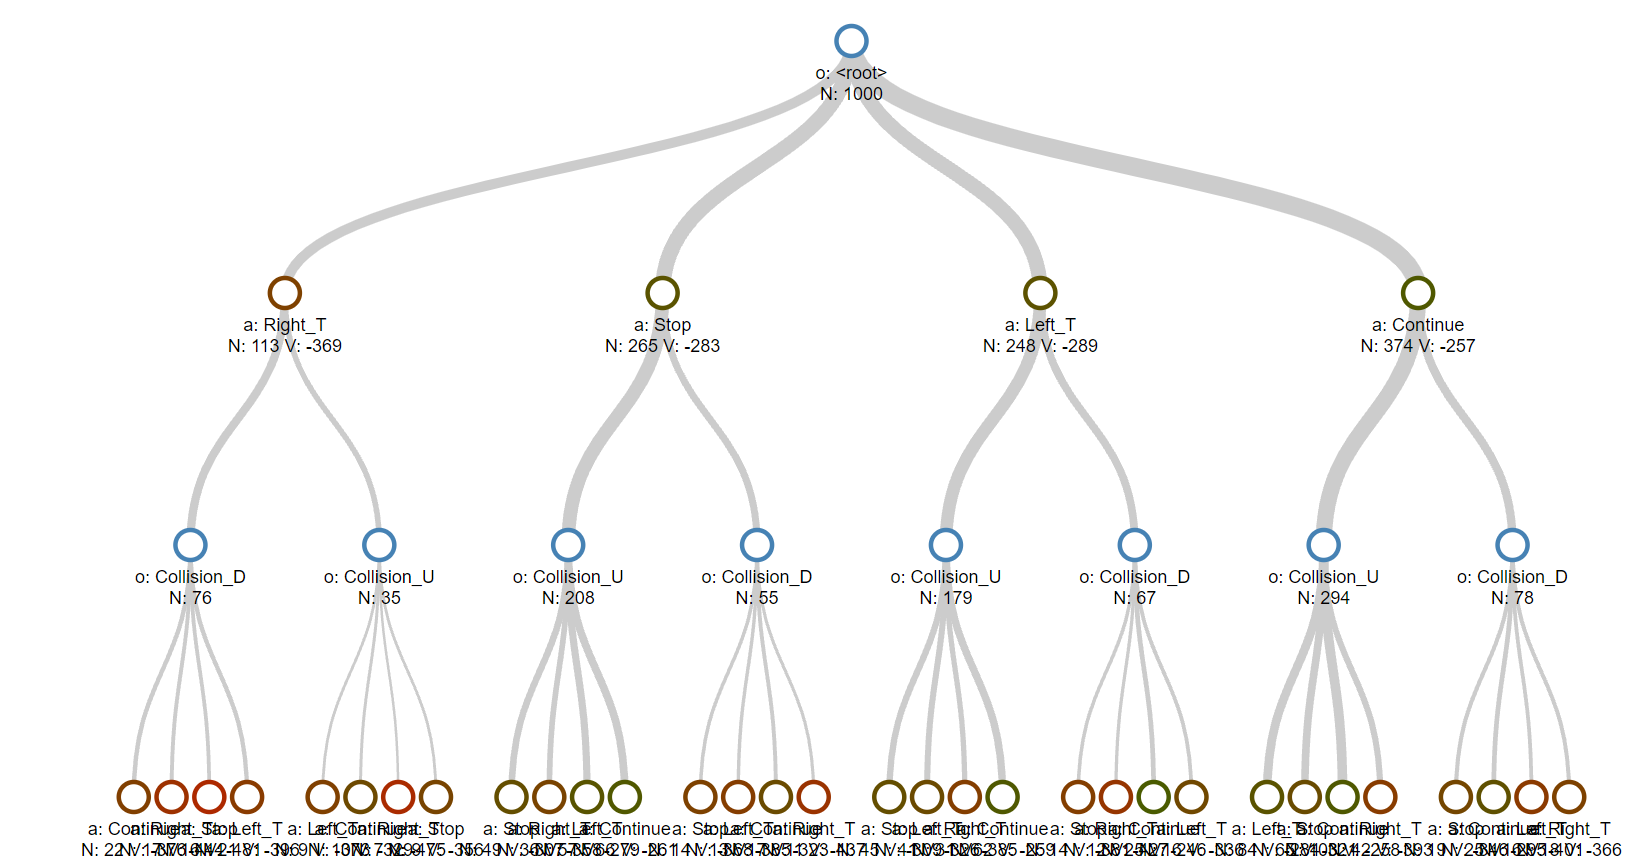

In [38]:
inchrome(pomcpow_tree)

Process(`cmd /C start chrome 'C:\Users\cveda\AppData\Local\Temp\jl_rOWBf4\tree.html'`, ProcessExited(0))

In [39]:
using POMDPs, POMDPModels, POMDPModelTools, D3Trees, ARDESPOT

In [40]:
solver = DESPOTSolver(bounds=(-20.0, 0.0), tree_in_info=true)
planner = solve(solver, pomdp)
b0 = initialstate_distribution(pomdp)

Deterministic{State}(Collision_AC)

In [41]:
a, info = action_info(planner, b0)
inchrome(D3Tree(info[:tree], init_expand=5))

Process(`cmd /C start chrome 'C:\Users\cveda\AppData\Local\Temp\jl_MQGzmJ\tree.html'`, ProcessExited(0))

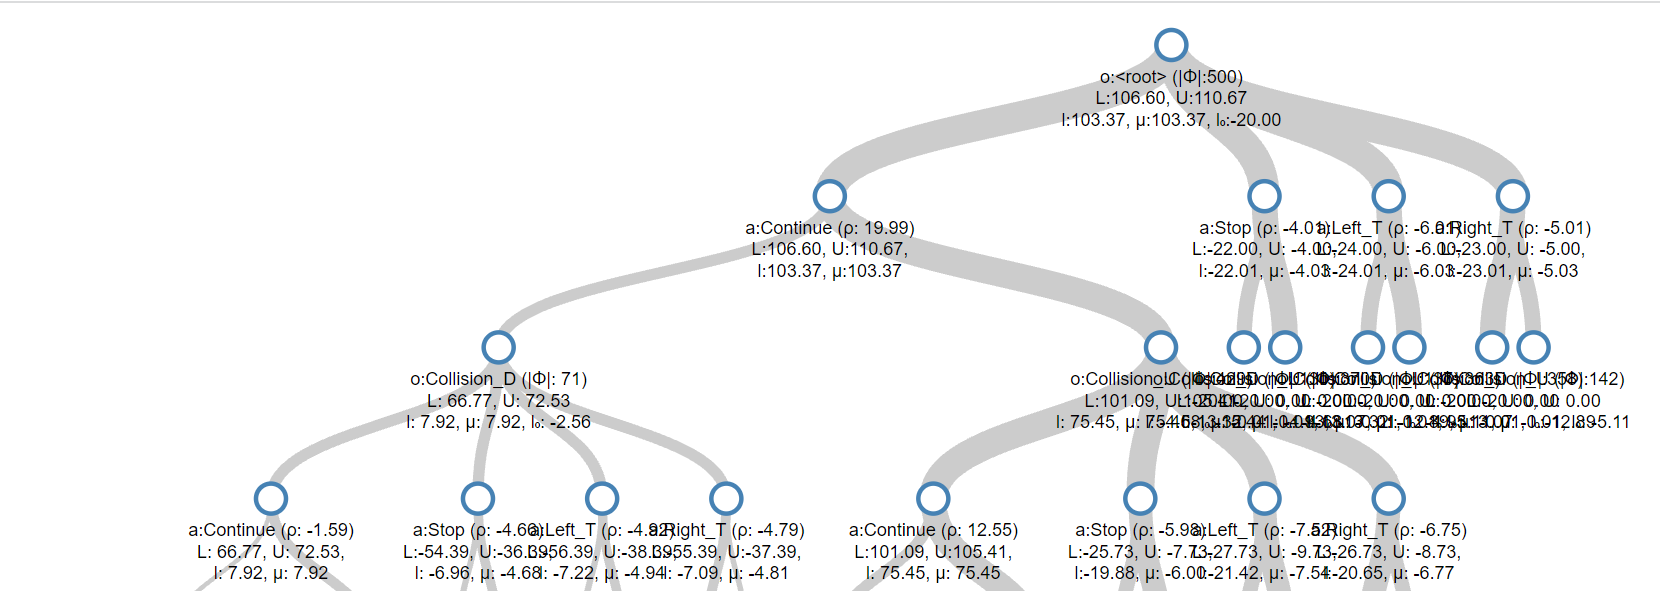